In [161]:
import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd
from scipy.spatial import distance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [163]:
# 1. Load CSV files
weather_df = pd.read_csv(r'D:\SVM\Edit 3 SVM\NYC_Weather_2019.csv')
grid_df = pd.read_csv(r'D:\SVM\Edit 3 SVM\nyc_data_cleaned_normalized [Grid ID + Ride Count].csv')

In [165]:
# 2. Clean weather data
for col in ['lat', 'lon', 'tmpf', 'relh', 'sped', 'p01i', 'vsby']:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
weather_df['lon'] = -weather_df['lon'].abs()
weather_df.dropna(subset=['lat', 'lon', 'tmpf', 'relh', 'sped', 'p01i', 'vsby'], inplace=True)

In [167]:
# 3. Weather stations
stations = {
    'Manhattan': {'lat': 40.7012, 'lon': -74.009},
    'NYC': {'lat': 40.779, 'lon': -73.9693},
}

In [169]:
# 4. Clean grid data
grid_df[['Min Lat', 'Max Lat', 'Min Long', 'Max Long']] = grid_df[['Min Lat', 'Max Lat', 'Min Long', 'Max Long']].astype(float)
grid_df.dropna(subset=['Min Lat', 'Max Lat', 'Min Long', 'Max Long'], inplace=True)
grid_df['geometry'] = grid_df.apply(lambda row: box(row['Min Long'], row['Min Lat'], row['Max Long'], row['Max Lat']), axis=1)
grid_gdf = gpd.GeoDataFrame(grid_df, geometry='geometry', crs="EPSG:4326")

In [171]:
# 5. Compute grid center and assign station
grid_gdf['center_lat'] = (grid_gdf['Min Lat'] + grid_gdf['Max Lat']) / 2
grid_gdf['center_lon'] = (grid_gdf['Min Long'] + grid_gdf['Max Long']) / 2

def closest_station(lat, lon):
    dists = {name: distance.euclidean((lat, lon), (s['lat'], s['lon'])) for name, s in stations.items()}
    return min(dists, key=dists.get)

grid_gdf['station'] = grid_gdf.apply(lambda row: closest_station(row['center_lat'], row['center_lon']), axis=1)

In [173]:
# 6. Sample weather data
def sample_weather_for_station(station_name):
    return weather_df[
        (weather_df['lat'].round(4) == round(stations[station_name]['lat'], 4)) &
        (weather_df['lon'].round(4) == round(stations[station_name]['lon'], 4))
    ]

for idx, row in grid_gdf.iterrows():
    station_name = row['station']
    samples = sample_weather_for_station(station_name)
    if not samples.empty:
        sampled_row = samples.sample(n=1, replace=True).iloc[0].to_dict()
        for key in ['tmpf', 'relh', 'sped', 'p01i', 'vsby', 'valid']:
            grid_gdf.at[idx, key] = sampled_row[key]

grid_gdf['lat'] = grid_gdf['center_lat']
grid_gdf['lon'] = grid_gdf['center_lon']

In [175]:
# 7. Classify weather: only Good and Bad ---
def classify_weather(Tmpf, Relh, WindSpeed, p01i, Vsby):
    if (60 <= Tmpf <= 85 and 30 <= Relh <= 60 and WindSpeed <= 15 and p01i == 0 and Vsby >= 5):
        return "Good Weather"
    else:
        return "Bad Weather"

In [177]:
# 8. Save to CSV
grid_gdf['Weather Condition'] = grid_gdf.apply(lambda row: classify_weather(row['tmpf'], row['relh'], row['sped'], row['p01i'], row['vsby']), axis=1)
grid_gdf.to_csv(r'D:\SVM\Edit 3 SVM\merged_weather_data.csv', index=False)

In [179]:
# 9. Load merged dataset ---
merged_df = pd.read_csv(r'D:\SVM\Edit 3 SVM\merged_weather_data.csv')

# Map and restrict only to Good/Bad
weather_condition_mapping = {'Good Weather': 1, 'Bad Weather': 0}
merged_df['Weather Condition'] = merged_df['Weather Condition'].map(weather_condition_mapping)
merged_df = merged_df[merged_df['Weather Condition'].isin([0, 1])]
# Parse time and extract hour
merged_df['valid'] = pd.to_datetime(merged_df['valid'], errors='coerce')
merged_df = merged_df.dropna(subset=['valid'])
merged_df['hour'] = merged_df['valid'].dt.hour
merged_df['lat'] = pd.to_numeric(merged_df['lat'], errors='coerce')
merged_df['lon'] = pd.to_numeric(merged_df['lon'], errors='coerce')
merged_df.dropna(subset=['lat', 'lon'], inplace=True)
merged_df['grid_id'] = ((merged_df['lat'] * 10).astype(int).astype(str) + "_" + (merged_df['lon'] * 10).astype(int).astype(str))
le = LabelEncoder()
merged_df['grid_id_encoded'] = le.fit_transform(merged_df['grid_id'])

In [181]:
# 10. Create binary classification target
merged_df['Weather Good/Bad'] = merged_df['Weather Condition']

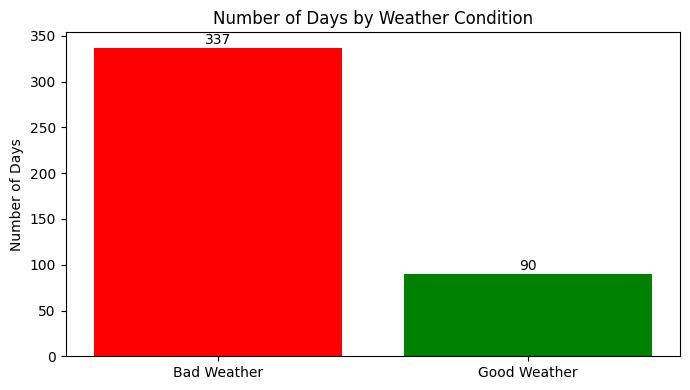

In [183]:
# 11. Visualization: Count of Days by Weather Condition ---
# duplicate weather entries per day
# counting the number of rows per day per weather, not the number of unique days per weather condition
weather_labels = {1: 'Good Weather', 0: 'Bad Weather'}
merged_df['day'] = merged_df['valid'].dt.date
weather_day_counts = merged_df.groupby(['day', 'Weather Condition']).size().reset_index(name='count')
day_summary = weather_day_counts.groupby('Weather Condition').size().reset_index(name='Number of Days')
day_summary['Label'] = day_summary['Weather Condition'].map(weather_labels)
colors = day_summary['Weather Condition'].map({1: 'green', 0: 'red'})

plt.figure(figsize=(7, 4))
bars = plt.bar(day_summary['Label'], day_summary['Number of Days'], color=colors)
plt.ylabel('Number of Days')
plt.title('Number of Days by Weather Condition')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

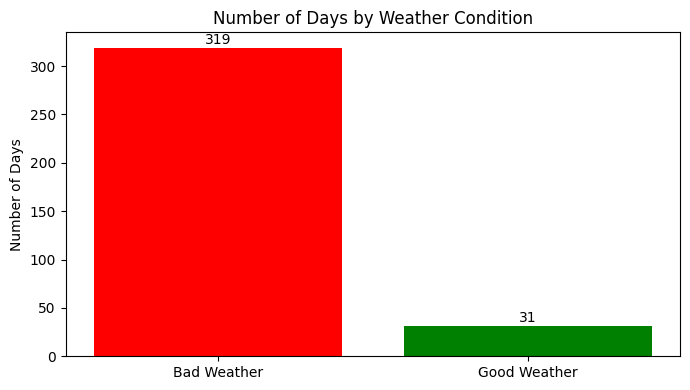

In [185]:
# 12. Visualization: Count of Days by Weather Condition ---
# 1 count per day
# Each day is labeled either "Good" or "Bad" based on the most frequent condition of that day.
# Fixes inflation caused by multiple hourly entries.

weather_labels = {1: 'Good Weather', 0: 'Bad Weather'}
merged_df['day'] = merged_df['valid'].dt.date

# FIX: Remove duplicate days, keep the dominant condition per day
daily_condition = merged_df.groupby(['day'])['Weather Condition'].agg(lambda x: x.mode()[0]).reset_index()
day_summary = daily_condition['Weather Condition'].value_counts().reset_index()
day_summary.columns = ['Weather Condition', 'Number of Days']
day_summary['Label'] = day_summary['Weather Condition'].map(weather_labels)
colors = day_summary['Weather Condition'].map({1: 'green', 0: 'red'})

plt.figure(figsize=(7, 4))
bars = plt.bar(day_summary['Label'], day_summary['Number of Days'], color=colors)
plt.ylabel('Number of Days')
plt.title('Number of Days by Weather Condition')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{int(yval)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [187]:
# 13. Weather Classification with GridSearchCV SVC (class_weight balanced) ---
X_classification = merged_df[['tmpf', 'relh', 'sped', 'p01i', 'vsby', 'Ride Count']]
y_classification = merged_df['Weather Good/Bad']
scaler = StandardScaler()
X_classification_scaled = scaler.fit_transform(X_classification)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification_scaled, y_classification, test_size=0.2, random_state=42)

svc = SVC(probability=True, class_weight='balanced')
svc_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf']
}
grid_svc = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy')
grid_svc.fit(X_train_class, y_train_class)
svc_best = grid_svc.best_estimator_
y_pred_class = svc_best.predict(X_test_class)

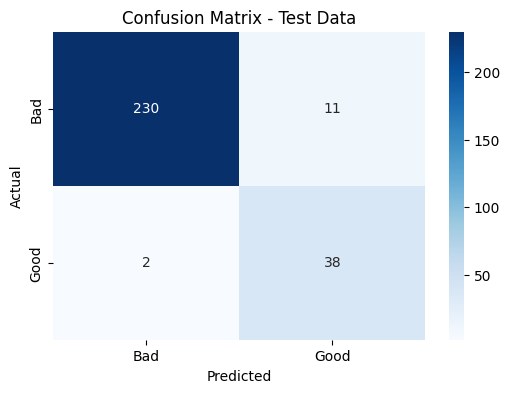

In [189]:
# 14. confusion_matrix
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.show()


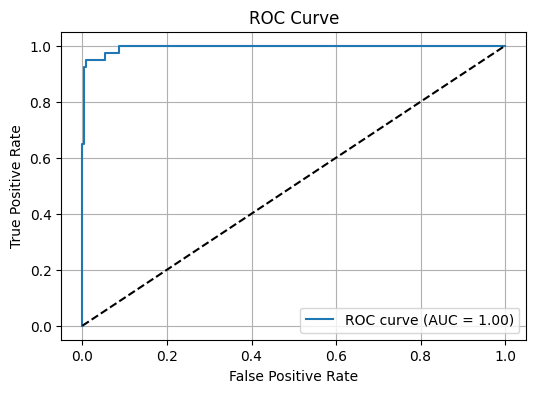

In [193]:
# 15. ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, svc_best.predict_proba(X_test_class)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [195]:
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=["Bad", "Good"]))



Classification Report:
              precision    recall  f1-score   support

         Bad       0.99      0.95      0.97       241
        Good       0.78      0.95      0.85        40

    accuracy                           0.95       281
   macro avg       0.88      0.95      0.91       281
weighted avg       0.96      0.95      0.96       281



In [197]:
# 16. Hourly Ridership Prediction (Gradient Boosting Regressor) ---
X_ridership = merged_df[['hour', 'grid_id_encoded', 'tmpf', 'relh', 'p01i', 'vsby', 'Weather Good/Bad']]
y_ridership = merged_df['Ride Count']

X_ridership_scaled = scaler.fit_transform(X_ridership)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_ridership_scaled, y_ridership, test_size=0.2, random_state=42)

gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train_r, y_train_r)
y_pred_r = gbr_model.predict(X_test_r)

print("Hourly Ridership Prediction (GradientBoostingRegressor)")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test_r, y_pred_r):.2f}")

Hourly Ridership Prediction (GradientBoostingRegressor)
MAE: 0.04
RMSE: 0.08


In [199]:
# 17. Good vs Bad Ride Ratio ---
good_weather_rides = merged_df[merged_df['Weather Good/Bad'] == 1]['Ride Count'].mean()
bad_weather_rides = merged_df[merged_df['Weather Good/Bad'] == 0]['Ride Count'].mean()
ride_ratio = good_weather_rides / bad_weather_rides if bad_weather_rides != 0 else np.nan

print(f"Avg Rides in Good Weather: {good_weather_rides:.2f}")
print(f"Avg Rides in Bad Weather: {bad_weather_rides:.2f}")
print(f"Ride Volume Ratio (Good / Bad): {ride_ratio:.2f}")

Avg Rides in Good Weather: 0.03
Avg Rides in Bad Weather: 0.03
Ride Volume Ratio (Good / Bad): 0.97


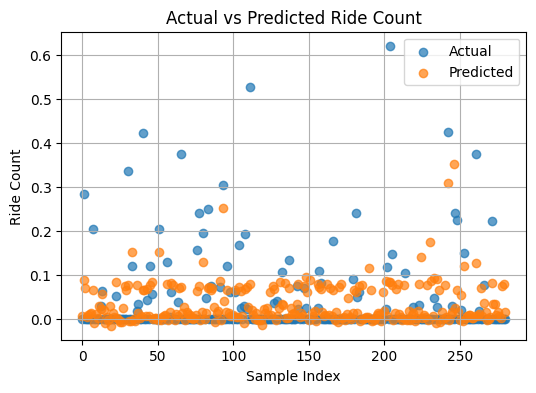

In [201]:
# 18. Visualize Actual vs Predicted for Hourly Prediction ---
plt.figure(figsize=(6, 4))
plt.scatter(range(len(y_test_r)), y_test_r, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test_r)), y_pred_r, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Ride Count')
plt.xlabel('Sample Index')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.show()

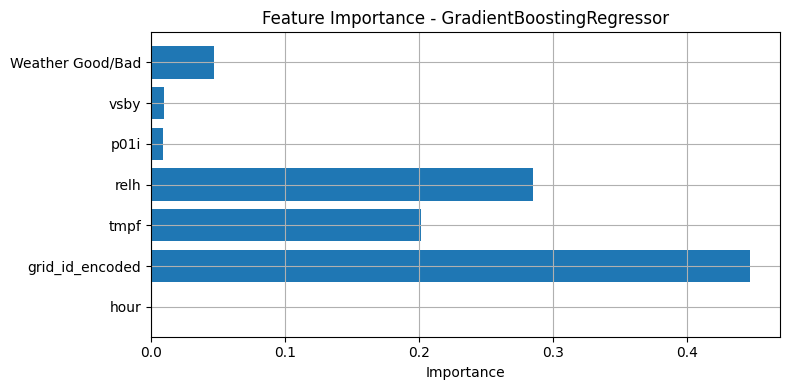

In [203]:
# 19. Visualize Feature Importance (GBR) ---
importances = gbr_model.feature_importances_
features = X_ridership.columns
plt.figure(figsize=(8, 4))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance - GradientBoostingRegressor")
plt.grid(True)
plt.tight_layout()
plt.show()

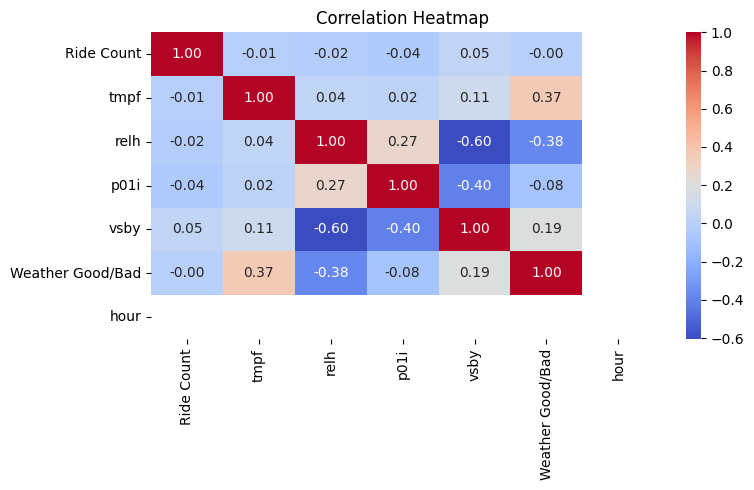

In [205]:
# 20. Correlation Heatmap ---
plt.figure(figsize=(8, 5))
sns.heatmap(merged_df[['Ride Count', 'tmpf', 'relh', 'p01i', 'vsby', 'Weather Good/Bad', 'hour']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

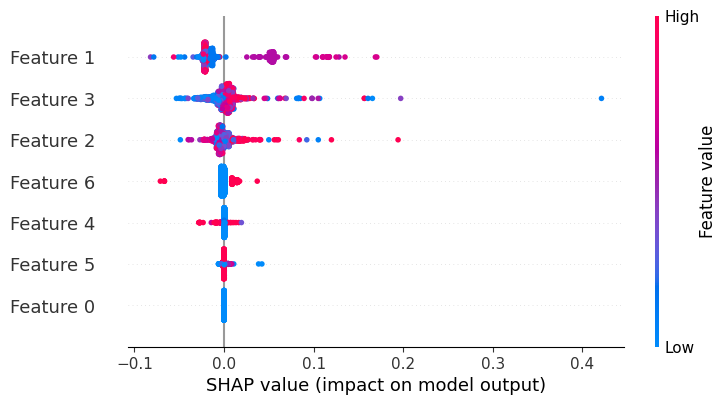

In [207]:
# 21. SHAP Summary Plot (Global Feature Importance) ---
import shap
explainer = shap.Explainer(gbr_model, X_train_r)
shap_values = explainer(X_train_r)

shap.plots.beeswarm(shap_values, max_display=10)

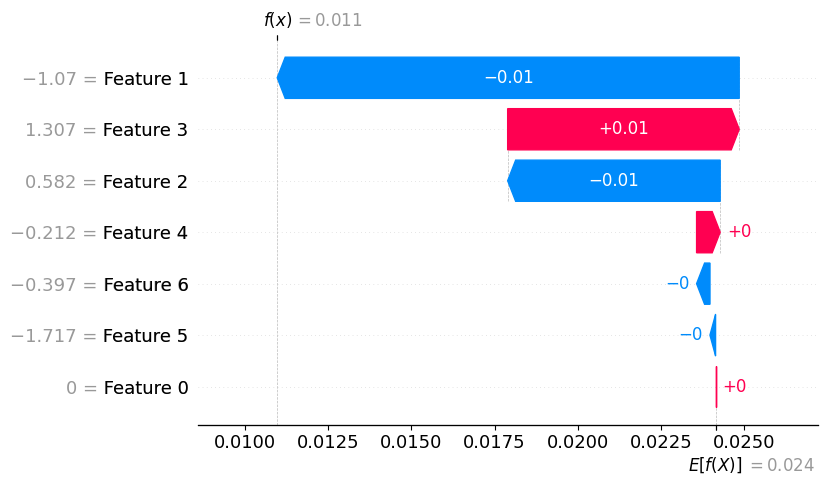

In [213]:
# 22. SHAP Force Plot / Waterfall Plot (First Sample) ---
shap.initjs()
shap.plots.waterfall(shap_values[0])
shap.plots.force(shap_values[0])

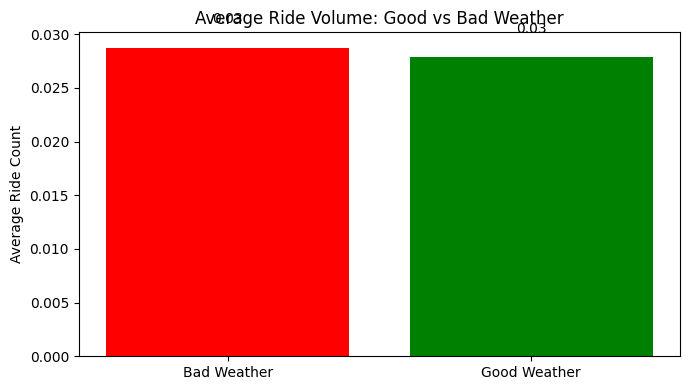

In [215]:
# 23. Visualization: Ride Volume Ratio (Good vs Bad Weather) ---
mean_vol = merged_df.groupby('Weather Condition', as_index=False)['Ride Count'].mean()
mean_vol['Label'] = mean_vol['Weather Condition'].astype(int).map(weather_labels)
colors = mean_vol['Weather Condition'].map({1: 'green', 0: 'red'}).tolist()

plt.figure(figsize=(7, 4))
bars = plt.bar(mean_vol['Label'], mean_vol['Ride Count'], color=colors)
plt.ylabel('Average Ride Count')
plt.title('Average Ride Volume: Good vs Bad Weather')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [217]:
# 24. Fix Hour Extraction ---
if 'valid' not in merged_df.columns:
    merged_df['valid'] = pd.to_datetime(weather_df['valid'], errors='coerce')
merged_df['hour'] = pd.to_datetime(merged_df['valid'], errors='coerce').dt.hour

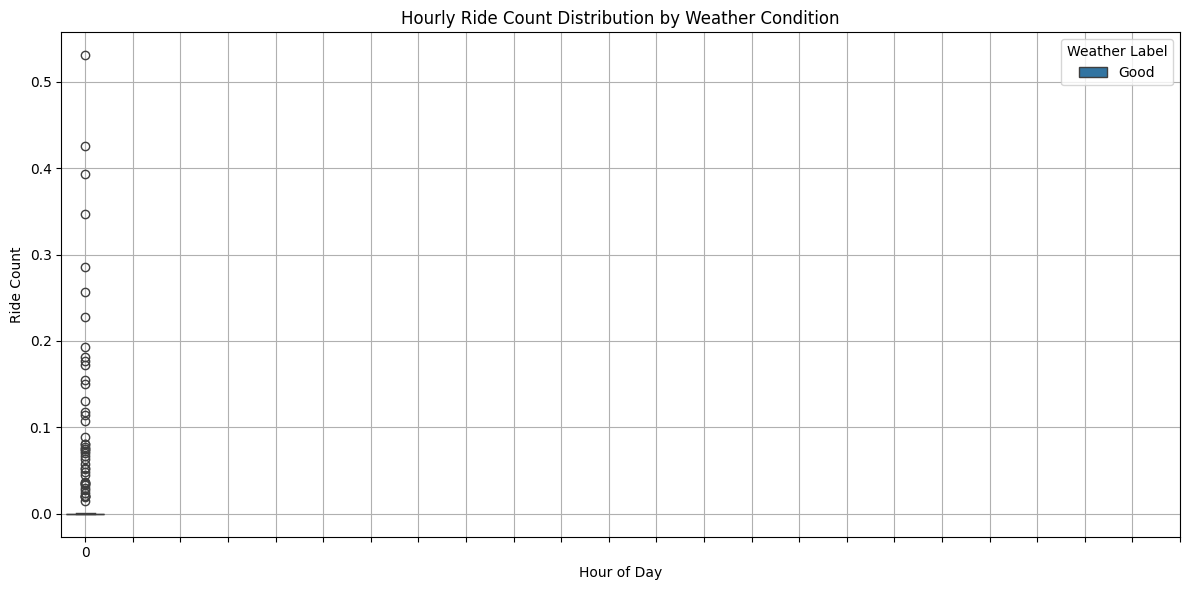

In [219]:
# 25. Visualization: Hourly Ridership by Weather Condition ---
plt.figure(figsize=(12, 6))
merged_df = merged_df.dropna(subset=['hour', 'Ride Count', 'Weather Condition'])
merged_df['hour'] = merged_df['hour'].astype(int)
merged_df['Ride Count'] = pd.to_numeric(merged_df['Ride Count'], errors='coerce')
merged_df = merged_df.dropna(subset=['Ride Count'])
merged_df = merged_df[merged_df['hour'].between(0, 23)]

# Alternative visualization: Boxplot
merged_df['Weather Label'] = merged_df['Weather Condition'].map({1: 'Good', 2: 'Moderate', 3: 'Bad'})

sns.boxplot(data=merged_df, x='hour', y='Ride Count', hue='Weather Label')
plt.title('Hourly Ride Count Distribution by Weather Condition')
plt.xlabel('Hour of Day')
plt.ylabel('Ride Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 26. Histogram: Ride Count Distribution by Weather Condition ---
plt.figure(figsize=(10, 6))
colors = ['green', 'red']
labels = ['Good', 'Bad']

for idx, condition in enumerate([1, 0]):
    subset = merged_df[merged_df['Weather Condition'] == condition]['Ride Count']
    if not subset.empty:
        plt.hist(subset, bins=30, alpha=0.5, color=colors[idx], label=labels[idx])

plt.title('Histogram of Ride Count by Weather Condition')
plt.xlabel('Ride Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

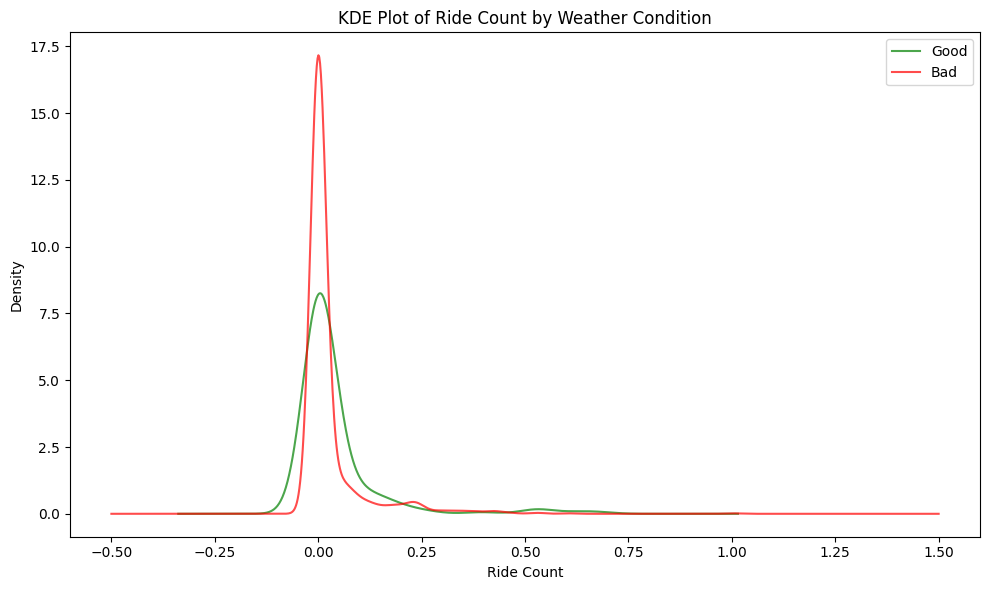

In [117]:
# --- KDE Plot: Ride Count Density by Weather Condition ---
plt.figure(figsize=(10, 6))
colors = ['green', 'red']
labels = ['Good', 'Bad']

for idx, condition in enumerate([1, 0]):
    subset = merged_df[merged_df['Weather Condition'] == condition]['Ride Count']
    subset.plot(kind='kde', color=colors[idx], label=labels[idx], alpha=0.7)

plt.title('KDE Plot of Ride Count by Weather Condition')
plt.xlabel('Ride Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

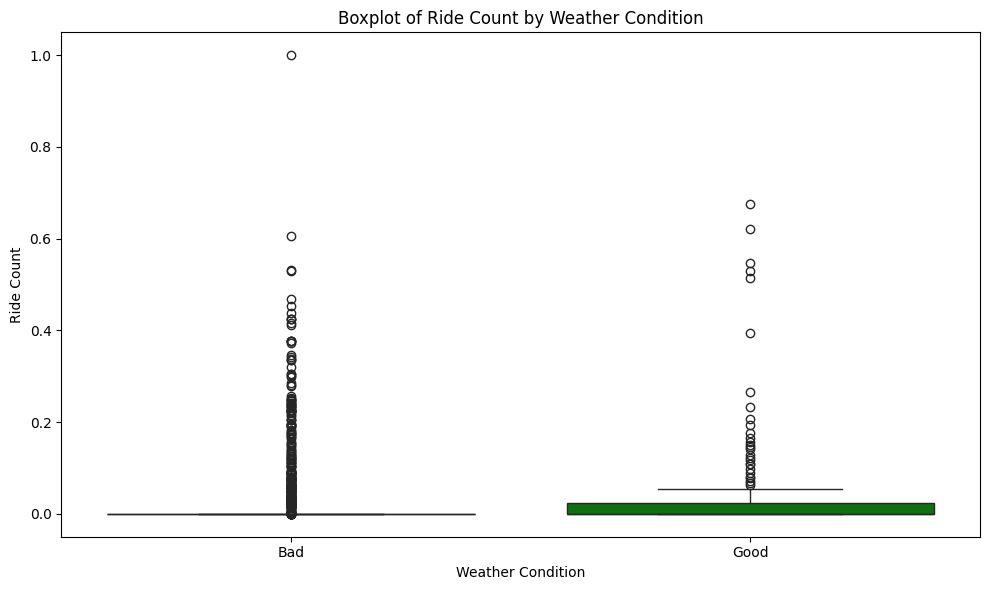

In [119]:
# --- Boxplot: Ride Count Distribution by Weather Condition ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather Condition', y='Ride Count', data=merged_df,
            hue='Weather Condition', palette={1: 'green', 0: 'red'}, legend=False)
plt.xticks(ticks=[0, 1], labels=['Bad', 'Good'])
plt.title('Boxplot of Ride Count by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Ride Count')
plt.tight_layout()
plt.show()

In [121]:
# --- Save outputs to files ---
pd.DataFrame({
    'Actual': y_test_r,
    'Predicted': y_pred_r
}).to_csv(r'D:\SVM\Edit 3 SVM\ride_predictions.csv', index=False)

report = classification_report(y_test_class, y_pred_class, target_names=["Bad", "Good"], output_dict=True)
pd.DataFrame(report).transpose().to_csv(r'D:\SVM\Edit 3 SVM\weather_classification_report.csv')

In [123]:
# --- Save confusion matrix and ROC curve as images ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_class, y_pred_class), annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.tight_layout()
plt.savefig(r'D:\SVM\Edit 3 SVM\confusion_matrix.png')
plt.close()

In [125]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(r'D:\SVM\Edit 3 SVM\roc_curve.png')
plt.close()

In [127]:
# --- Save best hyperparameters ---
with open(r'D:\SVM\Edit 3 SVM\best_svc_params.txt', 'w') as f:
    f.write(str(grid_svc.best_params_))